TODO: かなりラフに書いたので後でまとめること

In [1]:
## 同一ディレクトリ内にhttps://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g からダウンロードした学習済み単語ベクトルを配置しているものとする

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from gensim.models import KeyedVectors

DATASETPATH = '/content/drive/MyDrive/Colab Notebooks/NLP100/GoogleNews-vectors-negative300.bin' 

wv = KeyedVectors.load_word2vec_format(DATASETPATH, binary=True)

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-02-07 13:25:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  34.4MB/s    in 0.8s    

2023-02-07 13:25:03 (34.4 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [4]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [5]:
# 50
import collections
import csv
import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

CATEGORIES = [
    'b',
    't',
    'e',
    'm'
]

with open('./newsCorpora.csv') as f:
  reader = csv.reader(f, delimiter='\t')
  all_news = [[news[4], news[1]] for news in reader if news[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

In [6]:
# 70
import numpy as np


NEWS_CATEGORIES = {
    'b' : 0,
    't' : 1,
    'e' : 2,
    'm' : 3
}


def vector_create(X, filepath):
  for news in X:
    title, category = news[1], news[0]
    word_v = None
    for word in title.split(' '):
      if word:
        try:
          if word_v:
            word_v = word_v + wv[word] #. most_similarで抽出しようとするとメモリが死ぬため、データセットに存在する場合のみ扱う
          else:
            word_v = wv[word]
        except:
          continue
    if word_v is None:
      word_v = np.zeros(300)
    with open(f'./{filepath}_x.csv', mode='a') as f:
        f.write(str(','.join(list([str(char) for char in word_v]))) + '\n')
    y = NEWS_CATEGORIES[news[0]]
    with open(f'./{filepath}_y.csv', mode='a') as f:
      f.write(str(y) + '\n')

vector_create(train_data, 'train')
vector_create(valid_data, 'valid')
vector_create(test_data, 'test')

In [46]:
# 71
import csv
from scipy.special import softmax


X_14 = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    if i == 4:
      break
    X_14.append(row)
    i += 1
  X_14 = np.array(X_14, dtype=np.float64)

d = X_14.shape[1]
L = len(NEWS_CATEGORIES)
W = np.random.rand(d, L)

y_hat1 = softmax(np.dot(X_14[0], W))
print(f'y_hat1: {y_hat1}')

Y_hat = np.dot(X_14, W)

for i in range(L):
  Y_hat[i] = softmax(Y_hat[i])
print(f'Y_hat: {Y_hat}')


y_hat1: [0.061383   0.00865683 0.92206073 0.00789945]
Y_hat: [[0.061383   0.00865683 0.92206073 0.00789945]
 [0.14871856 0.0088378  0.80848438 0.03395926]
 [0.17435864 0.22262187 0.24568333 0.35733616]
 [0.29038719 0.40188268 0.15686196 0.15086816]]


In [53]:
# 72
Y_14 = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    if i == 4:
      break
    y = int(row.strip())
    Y = np.zeros(L)
    Y[y] = 1
    Y_14.append(Y)
    i += 1
Y_14 = np.array(Y_14)
p1 = np.dot(Y_hat[0], Y_14[0])

l1 =  -1 * np.log(p1)
print(f'l1: {l1}')
gradient1 = np.array([(Y_14[0][i] - Y_hat[0][i]) * X_14[0] for i in range(L)] )
print(f'gradient1: {gradient1}')

l1: 2.7906224276478926
(4, 300)
gradient1: [[ 0.16407465  0.30248399 -0.32814931 ... -0.1310764  -0.04606006
  -0.34464843]
 [-0.00151325 -0.0027898   0.00302651 ...  0.00120891  0.00042481
   0.00317868]
 [-0.16118054 -0.29714847  0.32236108 ...  0.12876434  0.04524761
   0.33856917]
 [-0.00138086 -0.00254572  0.00276172 ...  0.00110315  0.00038764
   0.00290058]]


In [55]:
ls = []
for i in range(4):
  p = np.dot(Y_hat[i], Y_14[i])
  l = -1 * np.log(p)
  ls.append(l)
gradient = gradient1
print(np.average(l))
for i in range(1,4):
  gradient += np.array([(Y_14[i][j] - Y_hat[i][j]) * X_14[i] for j in range(L)])
gradient = gradient / 4
print(f'gradient: {gradient}')

1.8523890697348653
gradient: [[ 0.00882465  0.1416841  -0.07776879 ...  0.01621055 -0.04644103
  -0.08891943]
 [-0.00021877 -0.0009998   0.02700808 ... -0.00492227 -0.00976538
   0.00416899]
 [-0.08675375 -0.06614857  0.0533893  ...  0.05702395 -0.01146217
   0.10401842]
 [ 0.07814787 -0.07453573 -0.00262859 ... -0.06831223  0.06766858
  -0.01926798]]


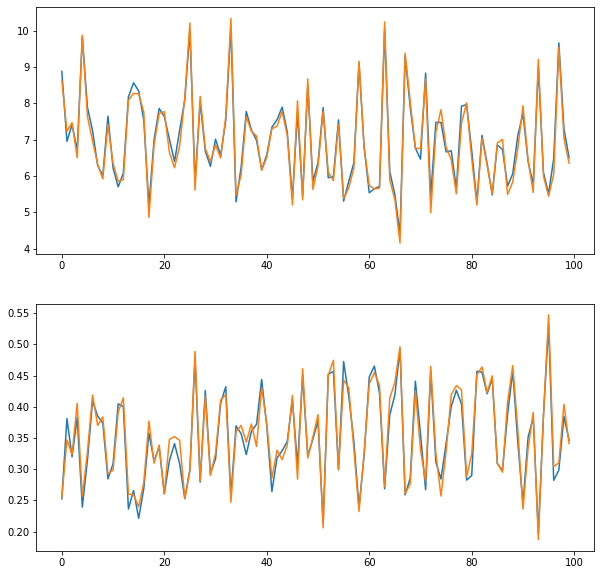

In [121]:
# 73 - 77
import matplotlib.pyplot as plt

EPOCH = 100

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  for row in data:
    X.append(row)
X = np.array(X, dtype=np.float64)

W = np.random.rand(d, L)

Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  for row in data:
    y = int(row.strip())
    _Y = np.zeros(L)
    _Y[y] = 1
    Y.append(_Y)
Y = np.array(Y)

valid_X = []
with open(f'./valid_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    valid_X.append(row)
    i += 1
valid_X = np.array(valid_X, dtype=np.float64)

valid_Y = []
with open(f'./valid_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    valid_Y.append(add_row)
    i += 1
valid_Y = np.array(valid_Y)

eta = 1.0
train_losses = []
train_correctness = []
test_losses = []
test_correctness = []
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_correctness))], train_correctness, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_correctness))], test_correctness, label="Accuracy(test)")
ax1.legend()
ax2.legend()
with open(f'./checkpoint.csv', mode='w') as f:
  writer = csv.writer(f)
  writer.writerow(['epoch', 'W', 'l', 'grad'])

for i in range(EPOCH):
  for x in X:
    i = np.random.randint(0, X.shape[0])
    p = softmax(np.dot(x, W))
    grad = Y[i] - p
    W = W.T
    index = np.where(Y[i] == 1)
    l += -1 * np.log(p[index])
    for j in range(grad.shape[0]):
      W[j] += eta * grad[j] * x
    W = W.T
  l = l/X.shape[0]
  with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow([i, W, l, grad])
  
  correct = 0
  l = 0
  for i in range(X.shape[0] - 1):
    p = softmax(np.dot(X[i], W))
    index = np.where(Y[i] == 1)
    l += -1 * np.log(p[index])
    max_index = np.where(p == np.max(p))
    if (Y[i][max_index] == 1)[0]:
      correct += 1
  train_losses.append(l/X.shape[0])
  train_correctness.append(correct/X.shape[0])

  correct = 0
  l = 0
  for i in range(valid_X.shape[0] - 1):
    p = softmax(np.dot(valid_X[i], W))
    index = np.where(valid_Y[i] == 1)
    l += -1 * np.log(p[index])
    max_index = np.where(p == np.max(p))
    if (valid_Y[i][max_index] == 1)[0]:
      correct += 1
  test_losses.append(l/valid_X.shape[0])
  test_correctness.append(correct/valid_X.shape[0])
  ax1.cla()
  ax2.cla()
  ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
  ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
  ax2.plot([i for i in range(len(train_correctness))], train_correctness, label="Accuracy(training)")
  ax2.plot([i for i in range(len(test_correctness))], test_correctness, label="Accuracy(test)")

plt.show() # TODO: 過程が表示されない


In [74]:
# 73 - 74別解
import numpy as np
from sklearn.linear_model import SGDClassifier

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)

Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  for row in data:
    Y.append(int(row.strip()))
Y = np.array(Y)
model = SGDClassifier(loss='log')
model.fit(X, Y)
W = model.coef_
print(W.T) # 73
print(model.score(X,Y)) # 74

[[-0.12257834 -0.24525419  0.69880653 -0.27370672]
 [-0.09255069  0.17632938 -0.12018343  0.31128402]
 [-0.03435071  0.36256959  0.31071887  0.18394012]
 ...
 [-0.12812148  0.43452563 -0.09537275  0.04123739]
 [-0.36163769 -0.84991163  0.7676875  -0.31699508]
 [-0.46174689 -0.35856945  0.43191252  0.67344149]]
0.7843890554722639
